# Classify gestures by reading muscle activity

# 실험 요약

# 선정한 데이터 설명 및 데이터 출처

사람이 근육을 사용하여 몸을 움직일 때는 근전도(EMG)라는 것이 발생한다. 근전도는 근육에 있는 신경섬유에서 나오는 전기적 신호들이 합쳐져 발생하며, 이를 통해 근육의 상태나 행동 특징에 대해 파악할 수 있다. 최근의 연구 결과를 살펴보면, 일반적인 근육의 상태나 움직임을 파악할 수 있는 것뿐만 아니라 근육 관련 질환, 나아가 파킨슨병까지 진단할 수 있다고 한다. 최근에는 MYO라는 간편한 휴대용 근전도 기록 기기가 나와 보다 간편하게 application을 만들 수 있게 되었다. 

이번 기말과제에서 선정한 데이터는 Kaggle에 공개된 데이터셋, 'Classify gestures by reading muscle activity: a recording of human hand muscle activity producing four different hand gestures' (https://www.kaggle.com/kyr7plus/emg-4/home) 다. 데이터 자체가 흥미로울 뿐만 아니라 추후 다양한 어플리케이션, 특히 헬스케어 등 다양한 분야로 확장할 수 있다는 점이 매력적으로 느껴져 기말과제 주제로 선정하였다. 또한 공간적, 시간적으로 의미가 있는 데이터인 것 같아 기존의 머신러닝 모델뿐만 아니라 해당 특징을 가진 데이터에 효과적인 딥러닝 모델을 적용할 때 성능이 어떻게 나올지 궁금하기도 했다.

이 데이터셋은 MYO라는 근전도 기록 기기로 4가지의 손동작(가위, 바위, 보, ok)을 기록한 데이터들로 이루어져 있다. 8개의 센서가 8개의 연속된 시점으로 기록되어, 하나의 instance당 64개의 feature를 가지고 있다. 각 class당 약 2900개 내외의 데이터를 가지고 있어 총 11,678개의 instance가 데이터셋으로 공개되었다. 각 데이터는 200 Hz로 기록되었는데 이는 40ms의 단위로 기록되었음을 의미한다.

데이터 형식은 아래와 같이 주어진다.

[8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]

그리고 gesture class는 rock - 0, scissors - 1, paper - 2, ok - 3로 주어진다.

따라서 이 기말과제의 목적은 EMG 데이터를 활용하여 손동작 클래스를 구분하는 Classification 문제를 푸는 것이다.

# 실험 설계 및 방법

    • 자신이 선정한 모델 및 모델 선정에 대한 이유
    • 분석에 시도한 trial 및 error 에 대한 설명(초기 모델에서 기대 이하의 성능이 나올 경우, 모델의 설정에 다양한 변화를 주고 validation 을 통해 개선되는 점을 보여줄 것)
    • Data set 을 train-set, validation-set, test-set 으로 구분하여 사용하며, 최종 모델 평가는 test-set 을 통해 평가
    • 실험 설계 및 평가 분석에 overfitting 의 관점이 사용되어야 함.

## 라이브러리 불러오기 

In [1]:
# 전처리, 자료형, 시각화 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 머신러닝 모델 라이브러리
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import keras

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# 데이터 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

## 데이터 불러오기 

In [4]:
# load csv files by class
data_rock = pd.read_csv('./emg-4/0.csv',header=None)
data_scissors = pd.read_csv('./emg-4/1.csv',header=None)
data_paper = pd.read_csv('./emg-4/2.csv',header=None)
data_ok = pd.read_csv('./emg-4/3.csv',header=None)

In [5]:
data = pd.concat([data_rock,data_scissors,data_paper,data_ok],axis=0,ignore_index=True) # 데이터 통합하기

## 데이터 탐색 

데이터의 특징을 간단하게 알아보고 및 preprocessing을 진행하기 위해, 데이터 탐색을 진행한다.

### data.info() 

data.info() 함수를 통해 각 column의 데이터 개수, null 여부, 자료형을 확인한다.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11678 entries, 0 to 11677
Data columns (total 65 columns):
0     11678 non-null float64
1     11678 non-null float64
2     11678 non-null float64
3     11678 non-null float64
4     11678 non-null float64
5     11678 non-null float64
6     11678 non-null float64
7     11678 non-null float64
8     11678 non-null float64
9     11678 non-null float64
10    11678 non-null float64
11    11678 non-null float64
12    11678 non-null float64
13    11678 non-null float64
14    11678 non-null float64
15    11678 non-null float64
16    11678 non-null float64
17    11678 non-null float64
18    11678 non-null float64
19    11678 non-null float64
20    11678 non-null float64
21    11678 non-null float64
22    11678 non-null float64
23    11678 non-null float64
24    11678 non-null float64
25    11678 non-null float64
26    11678 non-null float64
27    11678 non-null float64
28    11678 non-null float64
29    11678 non-null float64
30    11678 non-null 

### data.describe() 

data.describe() 함수를 통해 데이터의 평균, 표준편차, 최소/최대값, 4분위값을 알아본다.

In [7]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
count,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,...,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000
mean,-0.520380,-0.726837,-0.739082,-0.729748,-0.159103,-0.554890,-1.272649,-0.661843,-0.665953,-0.654222,...,-0.932694,-0.836958,-0.740623,-0.768710,-0.705343,-0.146686,-0.374807,-1.449306,-0.609094,1.503254
std,18.566709,11.766878,4.989944,7.441675,17.850402,25.809528,25.089972,15.408896,18.123854,11.841260,...,15.158993,18.204465,12.005206,4.969758,7.384410,17.841479,25.551082,25.259736,15.530091,1.117541
min,-116.000000,-104.000000,-33.000000,-75.000000,-121.000000,-122.000000,-128.000000,-128.000000,-110.000000,-128.000000,...,-128.000000,-116.000000,-128.000000,-46.000000,-74.000000,-103.000000,-128.000000,-128.000000,-124.000000,0.000000
25%,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-15.000000,-6.000000,-8.000000,-9.000000,-4.000000,...,-8.000000,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-14.000000,-6.000000,-8.000000,1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,2.000000
75%,7.000000,3.000000,2.000000,3.000000,10.000000,13.000000,4.000000,6.000000,6.000000,3.000000,...,6.000000,6.000000,3.000000,2.000000,3.000000,10.000000,13.000000,3.000000,6.000000,3.000000
max,111.000000,90.000000,34.000000,55.000000,92.000000,127.000000,127.000000,126.000000,127.000000,106.000000,...,114.000000,127.000000,105.000000,29.000000,51.000000,110.000000,127.000000,127.000000,127.000000,3.000000


### Histogram 그리기 

64개의 feature의 분포에 대해 Label별로 색깔을 정해(파랑-바위, 주황-가위, 초록-보, 빨강-ok) Histogram을 그려 시각화.

8x8 배열에서 row는 8개의 연속된 시점, column은 8개의 sensor로 생각하면 된다.

대부분 정규분포를 따르고 있는 것으로 보이며, outlier는 크게 보이지 않는다.

다만 7번째 sensor에서 바위 class의 deviation이 큰 것으로 관찰되어, 이 부분은 rule-based로 잘 구분할 수 있을 것으로 예상된다.

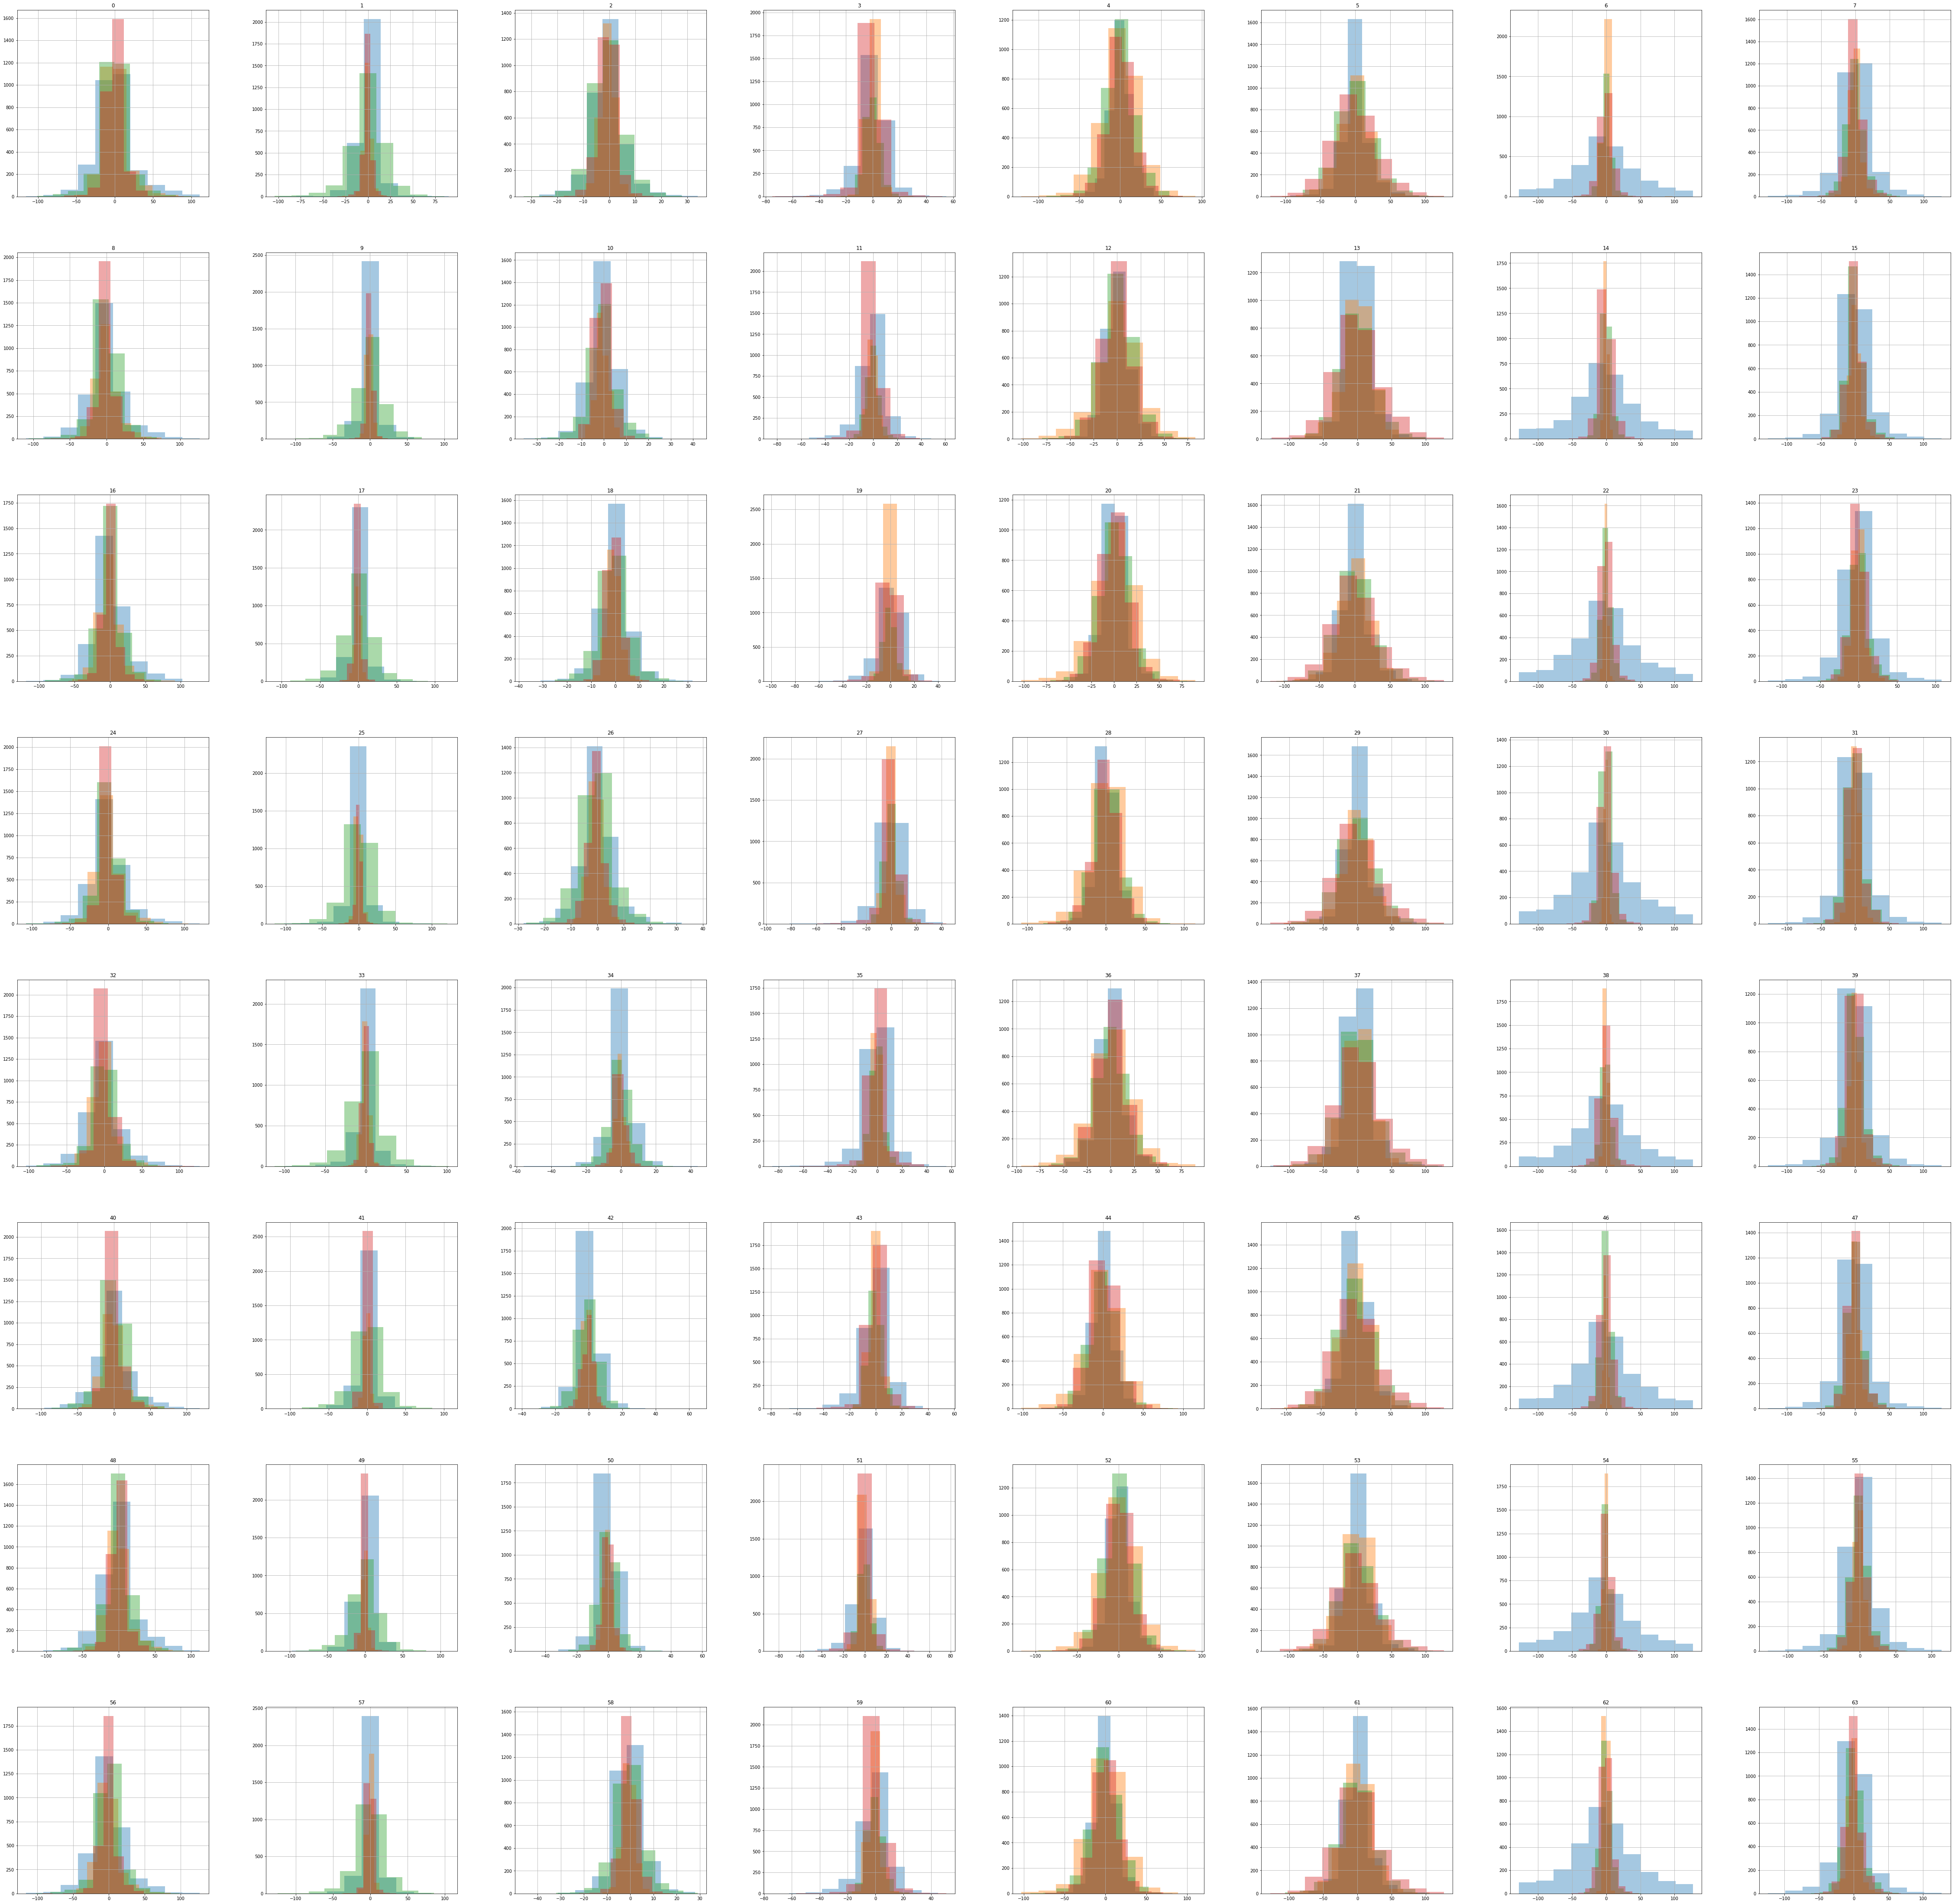

In [8]:
fig, axes = plt.subplots(8,8,figsize=(80,80))
for i in range(0,8):
    for j in range(0,8):
        data[[i*8+j,64]].groupby(64).hist(alpha=0.4,ax=axes[i][j])

plt.show()

## 데이터 train / test / validation 나누기 

60:20:20의 비율로 train / test / validation set을 나누었다.

In [9]:
X_train, X_, y_train, y_ = train_test_split(data.iloc[:,:64], data[64], test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [10]:
X_train.shape

(7006, 64)

In [11]:
X_test.shape

(2336, 64)

In [12]:
X_val.shape

(2336, 64)

In [13]:
y_train.shape

(7006,)

In [14]:
y_test.shape

(2336,)

In [15]:
y_val.shape

(2336,)

# 실험-모델 적용 

## Baseline

In [16]:
baseline_stratified = DummyClassifier("stratified")
baseline_most_frequent = DummyClassifier("most_frequent")
baseline_uniform = DummyClassifier("uniform")

In [17]:
baseline_stratified.fit(X_train,y_train)
baseline_most_frequent.fit(X_train,y_train)
baseline_uniform.fit(X_train,y_train)
print("baseline - stratified acc:",baseline_stratified.score(X_val,y_val))
print("baseline - most frequent acc:",baseline_most_frequent.score(X_val,y_val))
print("baseline - uniform acc:",baseline_uniform.score(X_val,y_val))

baseline - stratified acc: 0.2440068493150685
baseline - most frequent acc: 0.2512842465753425
baseline - uniform acc: 0.2478595890410959


In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import keras

## K Neigherest Neighbor 

In [19]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train,y_train)
print("K Neigherest Neighbor acc:",knn_classifier.score(X_val,y_val))

K Neigherest Neighbor acc: 0.6772260273972602


## Support Vector Machine 

In [20]:
svm_classifier = SVC()
svm_classifier.fit(X_train,y_train)
print("Support Vector Machine acc:",svm_classifier.score(X_val,y_val))

Support Vector Machine acc: 0.2512842465753425


## Decision Tree 

In [21]:
DT_classifier = DecisionTreeClassifier()
DT_classifier.fit(X_train,y_train)
print("Decition Tree acc:",DT_classifier.score(X_val,y_val))

Decition Tree acc: 0.7636986301369864


## Random Forest 

In [22]:
RF_classifier = RandomForestClassifier()
RF_classifier.fit(X_train,y_train)
print("Random Forest acc:",RF_classifier.score(X_val,y_val))

Random Forest acc: 0.8839897260273972


## Naïve Bayes

In [23]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train,y_train)
print("Naïve Bayes acc:",nb_classifier.score(X_val,y_val))

Naïve Bayes acc: 0.8728595890410958


## Multilayer Perceptron 

In [24]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train,y_train)
print("Multilayer Perceptron acc:",mlp_classifier.score(X_val,y_val))

Multilayer Perceptron acc: 0.8985445205479452


## CNN 

In [31]:
import keras.backend as K
from keras import models
from keras import layers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import to_categorical

In [121]:
def alexnet_variation(input_shape, n_classes):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32,(3,3),activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(256,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(512,(3,3),activation='relu',padding='same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

In [122]:
cnn = alexnet_variation(input_shape=(8,8,1),n_classes=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 512)         1180160   
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 512)         2359808   
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 512)         2359808   
__________

In [123]:
y_train_DL = to_categorical(y_train)
y_val_DL = to_categorical(y_val)
y_test_DL = to_categorical(y_test)
X_train_CNN = np.array(X_train).reshape(X_train.shape[0],8,8,1)
X_val_CNN = np.array(X_val).reshape(X_val.shape[0],8,8,1)
X_test_CNN = np.array(X_test).reshape(X_test.shape[0],8,8,1)

In [124]:
cnn.fit(X_train_CNN,y_train_DL,epochs=100,batch_size=2048,validation_data=(X_val_CNN,y_val_DL))

Train on 7006 samples, validate on 2336 samples
Epoch 1/100
7006/7006 [==============================] - 5s 748us/step - loss: 1.5065 - acc: 0.2712 - val_loss: 1.3869 - val_acc: 0.2513
Epoch 2/100
7006/7006 [==============================] - 1s 119us/step - loss: 1.3864 - acc: 0.2538 - val_loss: 1.3856 - val_acc: 0.2513
Epoch 3/100
7006/7006 [==============================] - 1s 118us/step - loss: 1.3850 - acc: 0.2538 - val_loss: 1.3807 - val_acc: 0.2513
Epoch 4/100
7006/7006 [==============================] - 1s 117us/step - loss: 1.3687 - acc: 0.3063 - val_loss: 1.3286 - val_acc: 0.3840
Epoch 5/100
7006/7006 [==============================] - 1s 117us/step - loss: 1.2849 - acc: 0.3650 - val_loss: 1.1742 - val_acc: 0.6229
Epoch 6/100
7006/7006 [==============================] - 1s 117us/step - loss: 1.1271 - acc: 0.6700 - val_loss: 1.1668 - val_acc: 0.5646
Epoch 7/100
7006/7006 [==============================] - 1s 117us/step - loss: 1.1465 - acc: 0.6086 - val_loss: 1.1121 - val_acc: 

7006/7006 [==============================] - 1s 118us/step - loss: 0.0012 - acc: 0.9993 - val_loss: 0.3660 - val_acc: 0.9568
Epoch 59/100
7006/7006 [==============================] - 1s 118us/step - loss: 0.0012 - acc: 0.9993 - val_loss: 0.3786 - val_acc: 0.9551
Epoch 60/100
7006/7006 [==============================] - 1s 119us/step - loss: 7.8646e-04 - acc: 0.9997 - val_loss: 0.4089 - val_acc: 0.9533
Epoch 61/100
7006/7006 [==============================] - 1s 121us/step - loss: 0.0042 - acc: 0.9989 - val_loss: 0.3321 - val_acc: 0.9580
Epoch 62/100
7006/7006 [==============================] - ETA: 0s - loss: 0.0136 - acc: 0.9946   - 1s 118us/step - loss: 0.0122 - acc: 0.9953 - val_loss: 0.3136 - val_acc: 0.9551
Epoch 63/100
7006/7006 [==============================] - ETA: 0s - loss: 0.0090 - acc: 0.996 - 1s 118us/step - loss: 0.0114 - acc: 0.9959 - val_loss: 0.3148 - val_acc: 0.9495
Epoch 64/100
7006/7006 [==============================] - ETA: 0s - loss: 0.1039 - acc: 0.976 - 1s 119

## RNN 

In [56]:
def simple_rnn(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.SimpleRNN(32, input_shape=input_shape))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

In [57]:
X_train_RNN = np.array(X_train).reshape(X_train.shape[0],8,8)
X_val_RNN = np.array(X_val).reshape(X_val.shape[0],8,8)
X_test_RNN = np.array(X_test).reshape(X_test.shape[0],8,8)

In [58]:
rnn = simple_rnn(input_shape=(8,8),n_classes=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 260       
Total params: 3,684
Trainable params: 3,684
Non-trainable params: 0
_________________________________________________________________


In [59]:
rnn.fit(X_train_RNN, y_train_DL, epochs=100,batch_size=2048,validation_data=(X_val_RNN,y_val_DL))

Train on 7006 samples, validate on 2336 samples
Epoch 1/100
7006/7006 [==============================] - 1s 81us/step - loss: 1.5040 - acc: 0.2242 - val_loss: 1.4548 - val_acc: 0.2376
Epoch 2/100
7006/7006 [==============================] - 0s 7us/step - loss: 1.4222 - acc: 0.2544 - val_loss: 1.3801 - val_acc: 0.2971
Epoch 3/100
7006/7006 [==============================] - 0s 7us/step - loss: 1.3555 - acc: 0.3190 - val_loss: 1.3225 - val_acc: 0.3771
Epoch 4/100
7006/7006 [==============================] - 0s 8us/step - loss: 1.3034 - acc: 0.3850 - val_loss: 1.2773 - val_acc: 0.4127
Epoch 5/100
7006/7006 [==============================] - 0s 7us/step - loss: 1.2604 - acc: 0.4276 - val_loss: 1.2398 - val_acc: 0.4473
Epoch 6/100
7006/7006 [==============================] - 0s 7us/step - loss: 1.2236 - acc: 0.4572 - val_loss: 1.2070 - val_acc: 0.4743
Epoch 7/100
7006/7006 [==============================] - 0s 7us/step - loss: 1.1906 - acc: 0.4793 - val_loss: 1.1776 - val_acc: 0.4940
Epoch 

7006/7006 [==============================] - 0s 8us/step - loss: 0.7341 - acc: 0.7148 - val_loss: 0.8320 - val_acc: 0.6657
Epoch 61/100
7006/7006 [==============================] - 0s 7us/step - loss: 0.7313 - acc: 0.7174 - val_loss: 0.8307 - val_acc: 0.6652
Epoch 62/100
7006/7006 [==============================] - 0s 6us/step - loss: 0.7287 - acc: 0.7177 - val_loss: 0.8295 - val_acc: 0.6661
Epoch 63/100
7006/7006 [==============================] - 0s 7us/step - loss: 0.7261 - acc: 0.7185 - val_loss: 0.8289 - val_acc: 0.6661
Epoch 64/100
7006/7006 [==============================] - 0s 7us/step - loss: 0.7235 - acc: 0.7201 - val_loss: 0.8282 - val_acc: 0.6678
Epoch 65/100
7006/7006 [==============================] - 0s 7us/step - loss: 0.7210 - acc: 0.7225 - val_loss: 0.8274 - val_acc: 0.6665
Epoch 66/100
7006/7006 [==============================] - 0s 7us/step - loss: 0.7185 - acc: 0.7245 - val_loss: 0.8263 - val_acc: 0.6678
Epoch 67/100
7006/7006 [==============================] - 0s 

## LSTM 

In [101]:
def LSTM(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.LSTM(32, input_shape=input_shape,return_sequences=True))
    model.add(layers.LSTM(64,return_sequences=True))
    model.add(layers.LSTM(128))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

In [102]:
lstm = LSTM(input_shape=(8,8),n_classes=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 8, 32)             5248      
_________________________________________________________________
lstm_23 (LSTM)               (None, 8, 64)             24832     
_________________________________________________________________
lstm_24 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 516       
Total params: 145,924
Trainable params: 145,924
Non-trainable params: 0
_________________________________________________________________


In [103]:
lstm.fit(X_train_RNN, y_train_DL, epochs=100,batch_size=2048,validation_data=(X_val_RNN,y_val_DL))

Train on 7006 samples, validate on 2336 samples
Epoch 1/100
7006/7006 [==============================] - 3s 401us/step - loss: 1.3756 - acc: 0.4012 - val_loss: 1.3375 - val_acc: 0.6691
Epoch 2/100
7006/7006 [==============================] - 0s 31us/step - loss: 1.3140 - acc: 0.6967 - val_loss: 1.2476 - val_acc: 0.7183
Epoch 3/100
7006/7006 [==============================] - 0s 31us/step - loss: 1.2022 - acc: 0.7362 - val_loss: 1.0759 - val_acc: 0.7461
Epoch 4/100
7006/7006 [==============================] - 0s 30us/step - loss: 0.9968 - acc: 0.7451 - val_loss: 0.8144 - val_acc: 0.7543
Epoch 5/100
7006/7006 [==============================] - 0s 31us/step - loss: 0.7315 - acc: 0.7531 - val_loss: 0.6057 - val_acc: 0.7598
Epoch 6/100
7006/7006 [==============================] - 0s 32us/step - loss: 0.5625 - acc: 0.7679 - val_loss: 0.5124 - val_acc: 0.8027
Epoch 7/100
7006/7006 [==============================] - 0s 30us/step - loss: 0.4805 - acc: 0.8099 - val_loss: 0.4675 - val_acc: 0.8142

Epoch 60/100
7006/7006 [==============================] - 0s 29us/step - loss: 0.0114 - acc: 0.9974 - val_loss: 0.2890 - val_acc: 0.9473
Epoch 61/100
7006/7006 [==============================] - 0s 29us/step - loss: 0.0097 - acc: 0.9977 - val_loss: 0.2982 - val_acc: 0.9473
Epoch 62/100
7006/7006 [==============================] - 0s 28us/step - loss: 0.0088 - acc: 0.9983 - val_loss: 0.3011 - val_acc: 0.9499
Epoch 63/100
7006/7006 [==============================] - 0s 29us/step - loss: 0.0080 - acc: 0.9983 - val_loss: 0.3131 - val_acc: 0.9443
Epoch 64/100
7006/7006 [==============================] - 0s 30us/step - loss: 0.0071 - acc: 0.9991 - val_loss: 0.3169 - val_acc: 0.9486
Epoch 65/100
7006/7006 [==============================] - 0s 30us/step - loss: 0.0069 - acc: 0.9987 - val_loss: 0.3301 - val_acc: 0.9439
Epoch 66/100
7006/7006 [==============================] - 0s 30us/step - loss: 0.0060 - acc: 0.9996 - val_loss: 0.3296 - val_acc: 0.9469
Epoch 67/100
7006/7006 [=================

## CNN-LSTM 

In [114]:
def CNN_LSTM(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.Conv1D(32,3,activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.Conv1D(64,3,activation='relu',padding='same'))
    model.add(layers.Conv1D(128,3,activation='relu',padding='same'))
    model.add(layers.Conv1D(256,3,activation='relu',padding='same'))
    model.add(layers.Conv1D(256,3,activation='relu',padding='same'))
    model.add(layers.LSTM(128, return_sequences = True))
    model.add(layers.LSTM(128, return_sequences = True))
    model.add(layers.LSTM(128, return_sequences = True))
    model.add(layers.LSTM(128))
    model.add(layers.Dense(256,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

In [115]:
cnn_lstm = CNN_LSTM(input_shape=(8,8),n_classes=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 8, 32)             800       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 8, 64)             6208      
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 8, 128)            24704     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 8, 256)            98560     
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 8, 256)            196864    
_________________________________________________________________
lstm_32 (LSTM)               (None, 8, 128)            197120    
_________________________________________________________________
lstm_33 (LSTM)               (None, 8, 128)            131584    
__________

In [116]:
cnn_lstm.fit(X_train_RNN, y_train_DL, epochs=100,batch_size=2048,validation_data=(X_val_RNN,y_val_DL))

Train on 7006 samples, validate on 2336 samples
Epoch 1/300
7006/7006 [==============================] - 4s 640us/step - loss: 1.3794 - acc: 0.3152 - val_loss: 1.3220 - val_acc: 0.4358
Epoch 2/300
7006/7006 [==============================] - 0s 54us/step - loss: 1.2731 - acc: 0.4215 - val_loss: 1.1665 - val_acc: 0.4461
Epoch 3/300
7006/7006 [==============================] - 0s 52us/step - loss: 1.0815 - acc: 0.4612 - val_loss: 0.9488 - val_acc: 0.5158
Epoch 4/300
7006/7006 [==============================] - 0s 51us/step - loss: 0.9364 - acc: 0.5307 - val_loss: 0.8614 - val_acc: 0.6246
Epoch 5/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.8511 - acc: 0.5926 - val_loss: 0.9040 - val_acc: 0.6182
Epoch 6/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.7864 - acc: 0.6550 - val_loss: 0.7492 - val_acc: 0.6233
Epoch 7/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.6730 - acc: 0.7005 - val_loss: 0.6375 - val_acc: 0.7363

Epoch 60/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.2231 - acc: 0.9148 - val_loss: 0.3043 - val_acc: 0.8955
Epoch 61/300
7006/7006 [==============================] - 0s 53us/step - loss: 0.1841 - acc: 0.9309 - val_loss: 0.3338 - val_acc: 0.8784
Epoch 62/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.1832 - acc: 0.9298 - val_loss: 0.2906 - val_acc: 0.9054
Epoch 63/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.1531 - acc: 0.9468 - val_loss: 0.2740 - val_acc: 0.9127
Epoch 64/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.1336 - acc: 0.9539 - val_loss: 0.2732 - val_acc: 0.9191
Epoch 65/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.1227 - acc: 0.9605 - val_loss: 0.3512 - val_acc: 0.8934
Epoch 66/300
7006/7006 [==============================] - 0s 53us/step - loss: 0.1703 - acc: 0.9405 - val_loss: 0.3052 - val_acc: 0.9097
Epoch 67/300
7006/7006 [=================

7006/7006 [==============================] - 0s 52us/step - loss: 0.0027 - acc: 0.9997 - val_loss: 0.4191 - val_acc: 0.9384
Epoch 120/300
7006/7006 [==============================] - 0s 53us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.4121 - val_acc: 0.9345
Epoch 121/300
7006/7006 [==============================] - 0s 53us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.4177 - val_acc: 0.9319
Epoch 122/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.4281 - val_acc: 0.9366
Epoch 123/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0027 - acc: 0.9997 - val_loss: 0.4376 - val_acc: 0.9366
Epoch 124/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.4246 - val_acc: 0.9328
Epoch 125/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0024 - acc: 0.9997 - val_loss: 0.4250 - val_acc: 0.9332
Epoch 126/300
7006/7006 [=======================

7006/7006 [==============================] - 0s 51us/step - loss: 0.0842 - acc: 0.9735 - val_loss: 0.2281 - val_acc: 0.9358
Epoch 179/300
7006/7006 [==============================] - ETA: 0s - loss: 0.0769 - acc: 0.977 - 0s 52us/step - loss: 0.0739 - acc: 0.9780 - val_loss: 0.2350 - val_acc: 0.9358
Epoch 180/300
7006/7006 [==============================] - ETA: 0s - loss: 0.0720 - acc: 0.978 - 0s 52us/step - loss: 0.0702 - acc: 0.9790 - val_loss: 0.2517 - val_acc: 0.9324
Epoch 181/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0626 - acc: 0.9813 - val_loss: 0.2487 - val_acc: 0.9341
Epoch 182/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0573 - acc: 0.9826 - val_loss: 0.2679 - val_acc: 0.9315
Epoch 183/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0522 - acc: 0.9842 - val_loss: 0.2538 - val_acc: 0.9349
Epoch 184/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0448 - acc: 0.9879 - val_los

Epoch 237/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.4144 - val_acc: 0.9345
Epoch 238/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.4032 - val_acc: 0.9362
Epoch 239/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.3922 - val_acc: 0.9354
Epoch 240/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.3949 - val_acc: 0.9354
Epoch 241/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.3967 - val_acc: 0.9366
Epoch 242/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.4192 - val_acc: 0.9332
Epoch 243/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.4158 - val_acc: 0.9345
Epoch 244/300
7006/7006 [=========

7006/7006 [==============================] - 0s 51us/step - loss: 0.0022 - acc: 0.9997 - val_loss: 0.4491 - val_acc: 0.9345
Epoch 297/300
7006/7006 [==============================] - 0s 51us/step - loss: 0.0020 - acc: 0.9997 - val_loss: 0.4414 - val_acc: 0.9345
Epoch 298/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0021 - acc: 0.9997 - val_loss: 0.4402 - val_acc: 0.9341
Epoch 299/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0022 - acc: 0.9997 - val_loss: 0.4402 - val_acc: 0.9349
Epoch 300/300
7006/7006 [==============================] - 0s 52us/step - loss: 0.0019 - acc: 0.9997 - val_loss: 0.4500 - val_acc: 0.9354


## Shallow CNN-LSTM 

In [125]:
def shallow_CNN_LSTM(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.Conv1D(32,3,activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.LSTM(64))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

In [126]:
shallow_cnn_lstm = shallow_CNN_LSTM(input_shape=(8,8),n_classes=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 8, 32)             800       
_________________________________________________________________
lstm_36 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_47 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_48 (Dense)             (None, 4)                 516       
Total params: 34,468
Trainable params: 34,468
Non-trainable params: 0
_________________________________________________________________


In [128]:
shallow_cnn_lstm.fit(X_train_RNN, y_train_DL, epochs=300,batch_size=2048,validation_data=(X_val_RNN,y_val_DL))

Train on 7006 samples, validate on 2336 samples
Epoch 1/300
7006/7006 [==============================] - 0s 14us/step - loss: 6.6309e-04 - acc: 1.0000 - val_loss: 0.2972 - val_acc: 0.9384
Epoch 2/300
7006/7006 [==============================] - 0s 13us/step - loss: 6.5115e-04 - acc: 1.0000 - val_loss: 0.2982 - val_acc: 0.9384
Epoch 3/300
7006/7006 [==============================] - 0s 13us/step - loss: 6.3063e-04 - acc: 1.0000 - val_loss: 0.2982 - val_acc: 0.9396
Epoch 4/300
7006/7006 [==============================] - 0s 13us/step - loss: 6.1624e-04 - acc: 1.0000 - val_loss: 0.2991 - val_acc: 0.9396
Epoch 5/300
7006/7006 [==============================] - 0s 13us/step - loss: 5.9706e-04 - acc: 1.0000 - val_loss: 0.3007 - val_acc: 0.9379
Epoch 6/300
7006/7006 [==============================] - 0s 13us/step - loss: 5.8611e-04 - acc: 1.0000 - val_loss: 0.3011 - val_acc: 0.9384
Epoch 7/300
7006/7006 [==============================] - 0s 13us/step - loss: 5.6966e-04 - acc: 1.0000 - val_los

Epoch 58/300
7006/7006 [==============================] - 0s 13us/step - loss: 2.1278e-04 - acc: 1.0000 - val_loss: 0.3292 - val_acc: 0.9401
Epoch 59/300
7006/7006 [==============================] - 0s 13us/step - loss: 2.0951e-04 - acc: 1.0000 - val_loss: 0.3296 - val_acc: 0.9405
Epoch 60/300
7006/7006 [==============================] - 0s 14us/step - loss: 2.0636e-04 - acc: 1.0000 - val_loss: 0.3299 - val_acc: 0.9401
Epoch 61/300
7006/7006 [==============================] - 0s 13us/step - loss: 2.0353e-04 - acc: 1.0000 - val_loss: 0.3302 - val_acc: 0.9401
Epoch 62/300
7006/7006 [==============================] - 0s 13us/step - loss: 2.0026e-04 - acc: 1.0000 - val_loss: 0.3307 - val_acc: 0.9401
Epoch 63/300
7006/7006 [==============================] - ETA: 0s - loss: 2.1269e-04 - acc: 1.000 - 0s 13us/step - loss: 1.9738e-04 - acc: 1.0000 - val_loss: 0.3313 - val_acc: 0.9401
Epoch 64/300
7006/7006 [==============================] - ETA: 0s - loss: 1.7069e-04 - acc: 1.000 - 0s 13us/step

7006/7006 [==============================] - 0s 13us/step - loss: 1.0394e-04 - acc: 1.0000 - val_loss: 0.3487 - val_acc: 0.9405
Epoch 115/300
7006/7006 [==============================] - 0s 13us/step - loss: 1.0276e-04 - acc: 1.0000 - val_loss: 0.3492 - val_acc: 0.9405
Epoch 116/300
7006/7006 [==============================] - 0s 13us/step - loss: 1.0166e-04 - acc: 1.0000 - val_loss: 0.3495 - val_acc: 0.9409
Epoch 117/300
7006/7006 [==============================] - 0s 13us/step - loss: 1.0069e-04 - acc: 1.0000 - val_loss: 0.3497 - val_acc: 0.9409
Epoch 118/300
7006/7006 [==============================] - 0s 14us/step - loss: 9.9573e-05 - acc: 1.0000 - val_loss: 0.3499 - val_acc: 0.9396
Epoch 119/300
7006/7006 [==============================] - 0s 14us/step - loss: 9.8553e-05 - acc: 1.0000 - val_loss: 0.3503 - val_acc: 0.9396
Epoch 120/300
7006/7006 [==============================] - 0s 13us/step - loss: 9.7465e-05 - acc: 1.0000 - val_loss: 0.3507 - val_acc: 0.9405
Epoch 121/300
7006/7

Epoch 171/300
7006/7006 [==============================] - 0s 13us/step - loss: 6.0474e-05 - acc: 1.0000 - val_loss: 0.3641 - val_acc: 0.9405
Epoch 172/300
7006/7006 [==============================] - 0s 13us/step - loss: 6.0022e-05 - acc: 1.0000 - val_loss: 0.3643 - val_acc: 0.9405
Epoch 173/300
7006/7006 [==============================] - 0s 13us/step - loss: 5.9488e-05 - acc: 1.0000 - val_loss: 0.3646 - val_acc: 0.9405
Epoch 174/300
7006/7006 [==============================] - ETA: 0s - loss: 5.8666e-05 - acc: 1.000 - 0s 13us/step - loss: 5.8911e-05 - acc: 1.0000 - val_loss: 0.3650 - val_acc: 0.9405
Epoch 175/300
7006/7006 [==============================] - 0s 13us/step - loss: 5.8478e-05 - acc: 1.0000 - val_loss: 0.3654 - val_acc: 0.9405
Epoch 176/300
7006/7006 [==============================] - 0s 13us/step - loss: 5.7978e-05 - acc: 1.0000 - val_loss: 0.3655 - val_acc: 0.9405
Epoch 177/300
7006/7006 [==============================] - 0s 13us/step - loss: 5.7485e-05 - acc: 1.0000 -

7006/7006 [==============================] - 0s 13us/step - loss: 3.9282e-05 - acc: 1.0000 - val_loss: 0.3759 - val_acc: 0.9409
Epoch 228/300
7006/7006 [==============================] - 0s 13us/step - loss: 3.9006e-05 - acc: 1.0000 - val_loss: 0.3762 - val_acc: 0.9409
Epoch 229/300
7006/7006 [==============================] - 0s 13us/step - loss: 3.8751e-05 - acc: 1.0000 - val_loss: 0.3764 - val_acc: 0.9409
Epoch 230/300
7006/7006 [==============================] - 0s 13us/step - loss: 3.8472e-05 - acc: 1.0000 - val_loss: 0.3765 - val_acc: 0.9409
Epoch 231/300
7006/7006 [==============================] - 0s 13us/step - loss: 3.8201e-05 - acc: 1.0000 - val_loss: 0.3767 - val_acc: 0.9409
Epoch 232/300
7006/7006 [==============================] - 0s 13us/step - loss: 3.7943e-05 - acc: 1.0000 - val_loss: 0.3769 - val_acc: 0.9409
Epoch 233/300
7006/7006 [==============================] - 0s 13us/step - loss: 3.7675e-05 - acc: 1.0000 - val_loss: 0.3771 - val_acc: 0.9409
Epoch 234/300
7006/7

7006/7006 [==============================] - 0s 13us/step - loss: 2.7166e-05 - acc: 1.0000 - val_loss: 0.3858 - val_acc: 0.9405
Epoch 285/300
7006/7006 [==============================] - 0s 13us/step - loss: 2.7000e-05 - acc: 1.0000 - val_loss: 0.3861 - val_acc: 0.9405
Epoch 286/300
7006/7006 [==============================] - 0s 13us/step - loss: 2.6844e-05 - acc: 1.0000 - val_loss: 0.3862 - val_acc: 0.9405
Epoch 287/300
7006/7006 [==============================] - ETA: 0s - loss: 2.4441e-05 - acc: 1.000 - 0s 13us/step - loss: 2.6686e-05 - acc: 1.0000 - val_loss: 0.3864 - val_acc: 0.9405
Epoch 288/300
7006/7006 [==============================] - 0s 13us/step - loss: 2.6528e-05 - acc: 1.0000 - val_loss: 0.3865 - val_acc: 0.9405
Epoch 289/300
7006/7006 [==============================] - ETA: 0s - loss: 2.6725e-05 - acc: 1.000 - 0s 13us/step - loss: 2.6365e-05 - acc: 1.0000 - val_loss: 0.3867 - val_acc: 0.9405
Epoch 290/300
7006/7006 [==============================] - 0s 13us/step - loss

## 결론